In [19]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import (
    draw_joint_point, )
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot

### Parametrization

#### 1) mechanism configuration

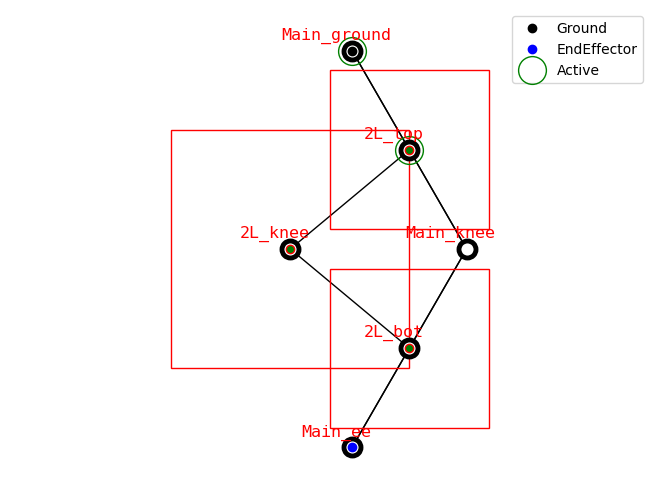

In [20]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0.3)
graph, constrain_dict = all_graphs[1]
actuator = TMotor_AK80_64()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

#### 2) set optimization task

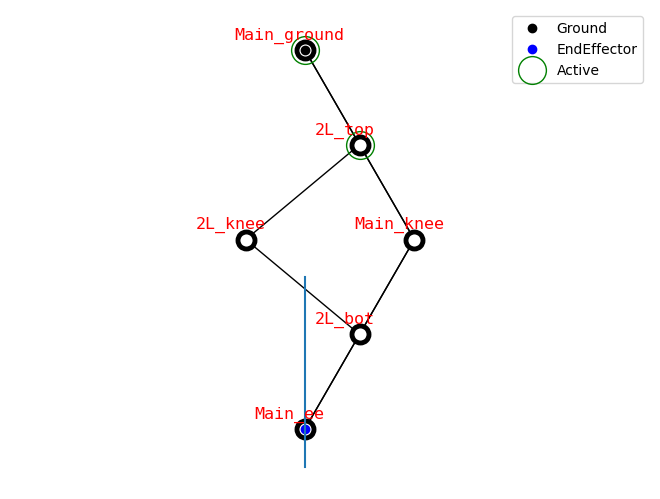

In [21]:
# trajectories
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.5, -0.95], step_height=0.4, step_width=1, n_points=50))
left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.65, -0.95], step_height=0.4, step_width=1, n_points=50))
right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.35, -0.95], step_height=0.4, step_width=1, n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-1.1, 0.5, 0, 50))
left_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-1.1, 0.5, -0.15, 50))
right_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-1.1, 0.5, 0.15, 50))

# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
# acceleration_capability = AccelerationCapability(manipulability_key='Manip_Jacobian',
#                                                  trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")
# rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1),
#                 (acceleration_capability, 1)]

step_trajectories = [ground_symmetric_step, left_shift_step, right_shift_step]
step_trajectories = [ground_symmetric_step]

heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")
rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1),
                    (heavy_lifting, 1)]

vertical_trajectories = [central_vertical, left_vertical, right_vertical]
vertical_trajectories = [central_vertical]

# rewards_and_trajectories = [
#     (rewards_step, step_trajectories), (rewards_vertical, vertical_trajectories)]
rewards_and_trajectories = [(rewards_vertical, vertical_trajectories)]
 

draw_joint_point(graph)

for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        
        plt.plot(trajectory[:, 0], trajectory[:, 2])
        

#### Calculate rewards for initial graph.

In [22]:
# create builder
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator, thickness=thickness)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
partial_rewards = []
for rewards, trajectories in rewards_and_trajectories:
    max_reward = -float('inf')
    max_partial = None
    best_trajectory = None
    for trajectory_id, trajectory in enumerate(trajectories):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        current_total = 0
        current_partial = []
        for reward, weight in rewards:
            current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
            current_total += weight*current_partial[-1]
        if current_total > max_reward:
            max_reward = current_total
            max_partial = current_partial
            best_trajectory_id = trajectory_id

    print(f'{type(rewards[0][0]).__name__}: ', max_partial[0])
    print(f'{type(rewards[1][0]).__name__}: ', max_partial[1])
 
    trajectory = trajectories[best_trajectory_id]
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards[1][0]
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])
    print(trajectory_criteria)
    


PositioningReward:  0
HeavyLiftingReward:  10.309025964218389
{'MASS': 4.307327743398028, 'POS_ERR': 0}


In [23]:
# activate multiprocessing
N_PROCESS = 16
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

In [24]:
population_size = 64
n_generations = 30

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            rewards_and_trajectories=rewards_and_trajectories,
                                            elementwise_runner=runner, Actuator = actuator)

saver = ProblemSaver(problem, "test_hopper", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=population_size, save_history=True, c2=3)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })


     1 |       64 |        - |       - |  0.9000 |  2.00000 |        3 | -5.820574E+00 | -3.739101E+01
     2 |      128 |  0.10367 |       3 |  0.4661 |  1.79554 |  2.32800 | -9.993555E+00 | -3.739101E+01
     3 |      192 |  0.04096 |       3 |  0.4258 |  1.74698 |  2.30291 | -1.967914E+01 | -3.739101E+01
     4 |      256 |  0.01187 |       3 |  0.4074 |  1.73171 |  2.30300 | -2.789068E+01 | -4.025870E+01
     5 |      320 | -8.6E-03 |       3 |  0.3947 |  1.72177 |  2.30398 | -3.270970E+01 | -4.490119E+01
     6 |      384 |  0.11996 |       3 |  0.4766 |  1.71722 |  2.31116 | -3.578410E+01 | -4.714097E+01
     7 |      448 |  0.02597 |       3 |  0.4163 |  1.71075 |  2.31498 | -3.775120E+01 | -4.985198E+01
     8 |      512 |  0.07367 |       3 |  0.4467 |  1.70489 |  2.31803 | -3.885016E+01 | -4.985198E+01
     9 |      576 |  0.04237 |       3 |  0.4267 |  1.70178 |  2.32516 | -4.008023E+01 | -4.985198E+01
    10 |      640 |  0.01008 |       3 |  0.4063 |  1.69617 |  2.32873 | 

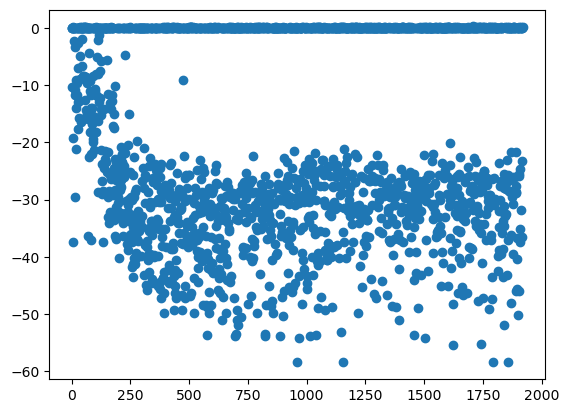

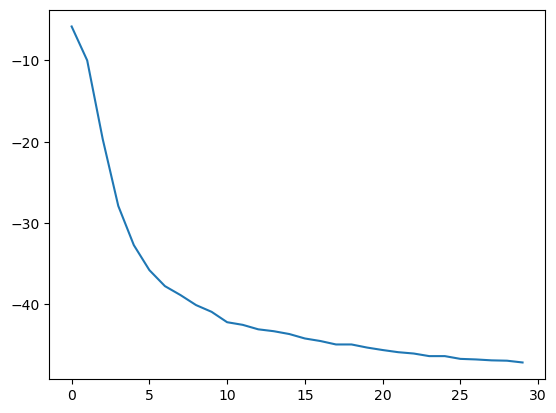

In [25]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

In [26]:
worst_id = np.argmax(optimizer.history["F"])
worst_reward = optimizer.history["F"][worst_id]
print('The maximum result in optimization task:', worst_reward.item())

The maximum result in optimization task: 0.28409001874713224


The minimum result in optimization task: [-58.50925388]


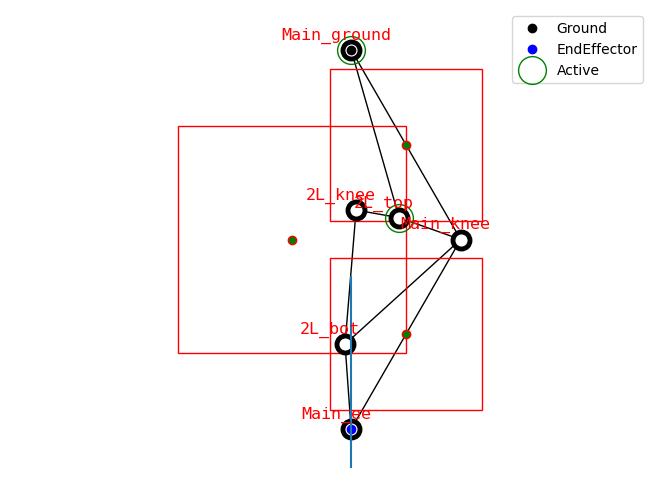

In [27]:
best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("The minimum result in optimization task:", best_reward)

problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])
visualize_constrains(problem.graph, constrain_dict)


In [28]:
best_reward_decomposition = optimizer.history["Fs"][best_id]
best_reward_decomposition

array([[ 0.        ,  0.        , 58.50925388]])

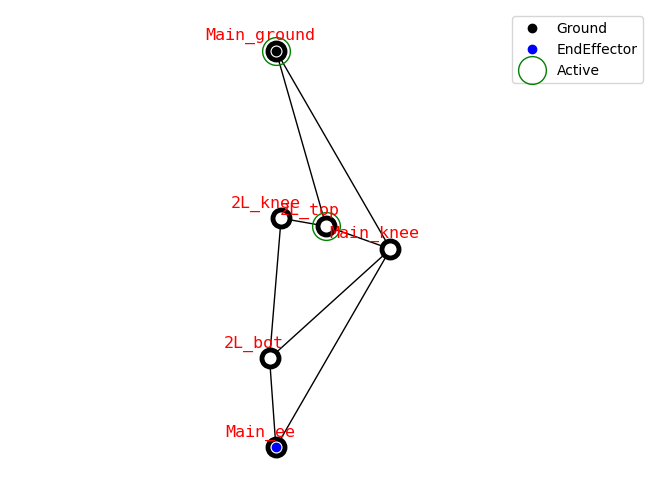

In [29]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

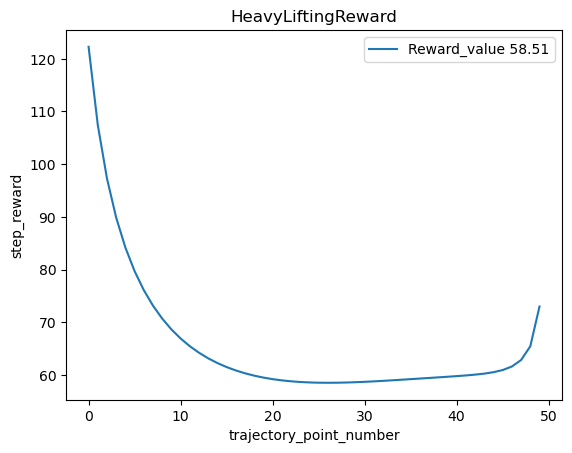

In [32]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)

reward_decomposition = best_reward_decomposition[0]
trajectory_id = int(reward_decomposition[0])
trajectory = rewards_and_trajectories[0][1][trajectory_id]

point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)

reward, reward_list = heavy_lifting.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)
reward_vector = np.array(reward_list)
plt.plot(reward_vector)
plt.xlabel('trajectory_point_number')
plt.ylabel('step_reward')
plt.title('HeavyLiftingReward')
plt.legend([f'Reward_value {round(reward,2)}'])

plt.show()


In [31]:
reward_vector

array([122.27115104, 107.42279878,  97.26516726,  89.83758339,
        84.1628545 ,  79.69200347,  76.08986569,  73.13886945,
        70.69086218,  68.64106753,  66.91302548,  65.44945669,
        64.20646566,  63.14973494,  62.25196237,  61.49109448,
        60.84902215,  60.31067463,  59.86336904,  59.4962678 ,
        59.20002024,  58.96642545,  58.78825826,  58.65905476,
        58.57295775,  58.52465689,  58.50925388,  58.52222809,
        58.55935685,  58.6167238 ,  58.69066428,  58.77777474,
        58.87490687,  58.97923904,  59.08825199,  59.19985294,
        59.31249015,  59.42525682,  59.53821841,  59.65274686,
        59.77214358,  59.90269567,  60.05545071,  60.24958193,
        60.51898481,  60.92660548,  61.59931232,  62.82773034,
        65.43470147,  72.97663144])